In [2]:
import IPython.core.display as di
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Show/Hide code</button>''', raw=True)

Show/Hide code

# Road load calculator

The utility reads speed vs time series from coastdown tests, and calculates road loads for a given vehicle (F0, F1, and F2). It is built following the GTR N 15 of WLTP - Annex 4.

The worflow is:
- Reading the speed time-series from an Excel file.
- Calculating, for each series, the times (in seconds) at which a given speed is reached.
- Calculating the forces associated to runs in opposite senses.
- Calculating the average force for a single run.
- Averaging the forces of several runs.
- Applying formulas to obtain F0, F1, and F2.
- Apply corrections to the road loads as foreseen in the GTR for different meteo conditions
- Providing the values of the default road loads according to the GTR (that depend essentially on mass, width, and height of the vehicle)

The utility (which may, at some point, be integrated in CO2MPAS) has to be able to:
- test the sensitivity to the use of precision of measures
- test the sensitivity to the number of pairs of runs
- test the sensitivity to the use of low speed data (<30 km/h)

In [3]:
#Allow the created content to be interactivelly ploted inline
%matplotlib notebook

In [4]:
#import needed libraries
import pandas as pd
import numpy as np
from scipy.stats import hmean
import matplotlib.pyplot as plt

# Data input

Enter either an input file with raw speed data (infile) **or** a file containing the processed times for each target speed (tinfile)

In [5]:
#Read excel input file (speed in km/h)
#infile = r'D:\Coast Down data TUEV\idiada\Nissan.xlsx'
#name of the excel tab containing the data
#tabname = 'Sheet1'

In [6]:
#Read excel input file (time in seconds for each target speed and run)
tinfile = r'D:\Coast Down data TUEV\idiada\Nissan-Low.xlsx'
#name of the excel tab containing the data
tabname = 'Sheet1'

In [7]:
#Set the total number of runs (if 4 in one sense and 4 in the other, set nr = 4; minimum 3)
nr = 10
#Set the recorded speed signal frequency (i.e 100 Hz set fr = 100; minimum 5 Hz)
fr = 100
#Set the speed targets of interest (usually 130 km/h to 20 km/h, each 10 km/h)
max_speed = 130
min_speed = 20
lag = 10
#set precision
precision = 6

### Vehicle characteristics

In [8]:
#mass in running order (kg). mro includes the vehicle mass (empty) + driver mass (75 kg) + fuel mass
mro = 2101.0
#rotational mass (kg). If unknown, the mr is calculated as (mro+25)*0.03
#mr = 
mr = 0.03*(mro+25)
#test mass (kg). testmass includes mro + mass of optional equipment + 25+ 0.15*(max laden mass - mro - mass of optional equipment)
testmass = 2372.0
#arithmetic average mass of the vehicle before and after the test
mav = 2366.0
#vehicle width (as defined in 6.2 of Standard ISO 612:1978, in meters)
width = 1.850
#vehicle height (as defined in 6.3 of Standard ISO 612:1978, in meters)
height = 1.805

### End of user choices ####

In [9]:
#read raw data
try:
    df = pd.read_excel(infile,tabname, skiprows=[1,2,3])
except:
    pass
#read times for target speeds
try:
    tdf = pd.read_excel(tinfile,tabname)
except:
    pass

In [10]:
#coastdown tests shall be transferred to forces by taking into account the applicable test mass + mr.
TM = testmass + mr
#target speeds
speeds = np.arange(min_speed, max_speed+1, lag)
speeds = speeds[::-1]
#coefficients for statistical precision
nt = [3,4,5,6,7,8,9,10,11,12,13,14,15]
coeff_h = [4.3,3.2,2.8,2.6,2.5,2.4,2.3,2.2,2.2,2.2,2.2,2.2,2.2]

For raw data

In [11]:
#Function that identifies the milisecond in which the car reaches a particular speed target (135 km/h, 125 km/h, etc.)
def find_nearest(array,value):
    idx = ((array-value)>=0).argmin()
    return idx

In [12]:
#Create the dataframe that indicates the time (in seconds) from the begining of the test till reaching a speed target for each run
#Note that following GTR 4.3.1.4.1, for a given speed, the coastdown time is identified as the difference of time 
#of the vehicle from speed+5 km/h - speed-5 km/h

# colnames_list=['w1', 'e1']
# for x in range(2, (nr+1)):
#     colnames_list.append('w%d' % (x))
#     colnames_list.append('e%d' % (x))
#     speedDF = pd.DataFrame(columns=colnames_list)
# for speed in speeds:
#     speedDF.loc[speed] = pd.Series({
#             'w1':(find_nearest(df['w1'], speed-5)-find_nearest(df['w1'], speed+5))/fr,'e1':(find_nearest(df['e1'], speed-5)-find_nearest(df['e1'], speed+5))/fr,
#             'w2':(find_nearest(df['w2'], speed-5)-find_nearest(df['w2'], speed+5))/fr,'e2':(find_nearest(df['e2'], speed-5)-find_nearest(df['e2'], speed+5))/fr,
#             'w3':(find_nearest(df['w3'], speed-5)-find_nearest(df['w3'], speed+5))/fr,'e3':(find_nearest(df['e3'], speed-5)-find_nearest(df['e3'], speed+5))/fr,
#             'w4':(find_nearest(df['w4'], speed-5)-find_nearest(df['w4'], speed+5))/fr,'e4':(find_nearest(df['e4'], speed-5)-find_nearest(df['e4'], speed+5))/fr,
#             'w5':(find_nearest(df['w5'], speed-5)-find_nearest(df['w5'], speed+5))/fr,'e5':(find_nearest(df['e5'], speed-5)-find_nearest(df['e5'], speed+5))/fr,
#             'w6':(find_nearest(df['w6'], speed-5)-find_nearest(df['w6'], speed+5))/fr,'e6':(find_nearest(df['e6'], speed-5)-find_nearest(df['e6'], speed+5))/fr,
#             'w7':(find_nearest(df['w7'], speed-5)-find_nearest(df['w7'], speed+5))/fr,'e7':(find_nearest(df['e7'], speed-5)-find_nearest(df['e7'], speed+5))/fr,
#             'w8':(find_nearest(df['w8'], speed-5)-find_nearest(df['w8'], speed+5))/fr,'e8':(find_nearest(df['e8'], speed-5)-find_nearest(df['e8'], speed+5))/fr,
#         })

For time data

In [13]:
speedDF = tdf.rename(columns={'n1': 'w1', 's1': 'e1','n2': 'w2', 's2': 'e2','n3': 'w3', 's3': 'e3',
                             'n4': 'w4', 's4': 'e4','n5': 'w5', 's5': 'e5','n6': 'w6', 's6': 'e6',
                             'n7': 'w7', 's7': 'e7',
                             'n8': 'w8', 's8': 'e8','n9': 'w9', 's9': 'e9','n10': 'w10', 's10': 'e10'})

### Speed dataframe for each individual run

In [14]:
speedDF

,w1,e1,w2,e2,w3,e3,w4,e4,w5,e5,w6,e6,w7,e7,w8,e8,w9,e9,w10,e10
130,5.24,5.09,5.24,5.23,5.55,5.08,5.32,4.63,5.62,4.91,5.39,4.89,5.59,4.77,5.37,4.73,5.53,4.66,5.54,4.75
120,5.92,5.55,5.75,5.50,5.49,5.63,5.91,5.92,5.96,5.91,6.02,5.57,6.23,5.54,6.17,5.35,6.34,5.56,5.90,5.43
110,6.56,5.84,6.70,6.12,6.74,6.24,6.56,5.69,6.79,6.31,6.57,6.15,6.48,6.15,6.68,6.11,6.38,6.30,6.60,5.98
100,7.57,6.90,7.66,7.46,8.17,6.92,7.64,7.30,7.84,7.07,8.08,6.78,7.96,6.88,7.86,7.13,7.83,6.66,7.60,7.06
90,8.79,8.35,9.26,8.51,8.33,7.94,8.98,8.03,9.49,7.88,9.10,8.10,8.94,7.81,8.75,7.60,8.85,7.97,8.53,7.64
80,10.25,9.03,10.62,9.66,10.42,9.54,10.41,9.04,10.98,9.22,10.78,8.84,10.46,9.08,9.88,8.92,10.50,8.49,10.36,9.02
70,12.46,10.85,12.69,10.76,12.58,10.65,12.96,10.54,12.96,10.45,12.75,10.12,11.84,10.30,12.79,10.25,12.69,10.85,12.81,10.28
60,15.82,11.95,14.67,12.52,15.25,11.99,14.74,11.90,14.78,12.02,15.13,11.58,14.97,11.71,15.22,11.77,14.98,11.95,15.25,11.58
50,17.95,13.64,17.31,13.16,18.31,13.60,17.78,13.26,17.99,13.49,17.73,13.70,18.16,13.55,17.63,13.42,18.33,13.33,18.54,13.21
40,19.65,15.15,19.97,15.34,22.02,15.16,20.07,15.36,20.86,15.00,20.15,14.64,20.04,14.94,21.30,15.20,19.98,15.61,20.22,15.33


Harmonic averages of times (sec) for runs on both directions of the track

In [15]:
hcolnames_list=['r1']
for x in range(2, (nr+1)):
    hcolnames_list.append('r%d' % (x))
    hspeedDF = pd.DataFrame(columns=hcolnames_list)
for speed in speeds:
    hspeedDF.loc[speed] = pd.Series({
            'r1':hmean([speedDF.loc[speed]['w1'],speedDF.loc[speed]['e1']],dtype=np.float64),
            'r2':hmean([speedDF.loc[speed]['w2'],speedDF.loc[speed]['e2']],dtype=np.float64),
            'r3':hmean([speedDF.loc[speed]['w3'],speedDF.loc[speed]['e3']],dtype=np.float64),
            'r4':hmean([speedDF.loc[speed]['w4'],speedDF.loc[speed]['e4']],dtype=np.float64),
            'r5':hmean([speedDF.loc[speed]['w5'],speedDF.loc[speed]['e5']],dtype=np.float64),
            'r6':hmean([speedDF.loc[speed]['w6'],speedDF.loc[speed]['e6']],dtype=np.float64),
            'r7':hmean([speedDF.loc[speed]['w7'],speedDF.loc[speed]['e7']],dtype=np.float64),
            'r8':hmean([speedDF.loc[speed]['w8'],speedDF.loc[speed]['e8']],dtype=np.float64),
            'r9':hmean([speedDF.loc[speed]['w9'],speedDF.loc[speed]['e9']],dtype=np.float64),
            'r10':hmean([speedDF.loc[speed]['w10'],speedDF.loc[speed]['e10']],dtype=np.float64),
        })
hspeedDF = hspeedDF.round(precision)
hspeedDF

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10
130,5.163911,5.234995,5.304610,4.951075,5.241064,5.127840,5.147548,5.029723,5.057861,5.114674
120,5.729032,5.622222,5.559119,5.914996,5.934895,5.786264,5.864775,5.730816,5.924437,5.655252
110,6.179097,6.396880,6.480370,6.094106,6.541206,6.353066,6.310689,6.382299,6.339748,6.274722
100,7.219489,7.558677,7.493227,7.466131,7.435117,7.373136,7.380701,7.477225,7.197764,7.320055
90,8.564352,8.869173,8.130326,8.478471,8.610386,8.570930,8.336884,8.134557,8.386980,8.060507
80,9.601400,10.117278,9.960601,9.676751,10.023327,9.714088,9.721269,9.375489,9.388626,9.643674
70,11.599399,11.645578,11.534826,11.625396,11.570440,11.283778,11.016441,11.379991,11.698088,11.406392
60,13.615340,13.509996,13.424927,13.168619,13.257881,13.119086,13.140832,13.274502,13.294541,13.163996
50,15.500981,14.952386,15.607396,15.190902,15.418367,15.456634,15.519899,15.239588,15.435180,15.427616
40,17.109052,17.351447,17.957138,17.401931,17.451199,16.958666,17.118216,17.740274,17.526710,17.438684


arithmetic average of the coastdown time at reference speed (sec)

In [16]:
avcdt = pd.DataFrame(columns = ['arithm avg coastdown time'])
for speed in speeds:
    avcdt.loc[speed]= pd.Series({
            'arithm avg coastdown time':(nr/(sum(1/hspeedDF.loc[speed]))),
        })
avcdt = avcdt.round(precision)
avcdt

,arithm avg coastdown time
130,5.135333
120,5.769330
110,6.332730
100,7.390439
90,8.407298
80,9.716530
70,11.472567
60,13.295068
50,15.372677
40,17.400715


Standard deviation of coastdown times at reference speed (sec)

In [17]:
dif_speedDF = pd.DataFrame(columns = hcolnames_list)
std_timesDF = pd.DataFrame(columns = ['std.dev times'])
for speed in speeds:
    dif_speedDF.loc[speed] = pd.Series({
            'r1':(hspeedDF['r1'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
            'r2':(hspeedDF['r2'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
            'r3':(hspeedDF['r3'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
            'r4':(hspeedDF['r4'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
            'r5':(hspeedDF['r5'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
            'r6':(hspeedDF['r6'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
            'r7':(hspeedDF['r7'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
            'r8':(hspeedDF['r8'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
            'r9':(hspeedDF['r9'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
            'r10':(hspeedDF['r10'][speed]-avcdt['arithm avg coastdown time'][speed])**2,
        })
    std_timesDF.loc[speed] = pd.Series({
            'std.dev times':np.sqrt(sum(dif_speedDF.loc[speed])*(1/(nr-1))),
            })
std_timesDF = std_timesDF.round(precision)
std_timesDF

,std.dev times
130,0.106626
120,0.135004
110,0.131947
100,0.118238
90,0.255564
80,0.249064
70,0.208255
60,0.168446
50,0.193417
40,0.299533


Statistical precision (pj) (according to 4.3.1.4.2). If pj <= 0.03 the statistical precision is satisfied for 
a given speed target

In [18]:
pj = pd.DataFrame(columns = ['statistical precision'])
for speed in speeds:
    pj.loc[speed] = pd.Series({
            'statistical precision':(coeff_h[nr-3]*std_timesDF['std.dev times'][speed])
            /(np.sqrt(nr) * avcdt['arithm avg coastdown time'][speed]),
        })
pj = pj.round(precision)
pj

,statistical precision
130,0.014445
120,0.016280
110,0.014495
100,0.011130
90,0.021148
80,0.017833
70,0.012629
60,0.008814
50,0.008753
40,0.011976


## Forces calculation

Arithmetic averages of coastdown times for runs on each direction of the track

In [19]:
rspeedDF = pd.DataFrame(columns=['west','east'])
for speed in speeds:
    rspeedDF.loc[speed] = pd.Series({
            'west':np.mean([speedDF.loc[speed]['w1'],speedDF.loc[speed]['w2'],speedDF.loc[speed]['w3'],speedDF.loc[speed]['w4'],speedDF.loc[speed]['w5'],speedDF.loc[speed]['w6'],speedDF.loc[speed]['w7'],speedDF.loc[speed]['w8'],speedDF.loc[speed]['w9'],speedDF.loc[speed]['w10']],dtype=np.float64),#
            'east':np.mean([speedDF.loc[speed]['e1'],speedDF.loc[speed]['e2'],speedDF.loc[speed]['e3'],speedDF.loc[speed]['e4'],speedDF.loc[speed]['e5'],speedDF.loc[speed]['e6'],speedDF.loc[speed]['e7'],speedDF.loc[speed]['e8'],speedDF.loc[speed]['e9'],speedDF.loc[speed]['e10']],dtype=np.float64),#            
        })
rspeedDF = rspeedDF.round(precision)
rspeedDF

,west,east
130,5.439,4.874
120,5.969,5.596
110,6.606,6.089
100,7.821,7.016
90,8.902,7.983
80,10.466,9.084
70,12.653,10.505
60,15.081,11.897
50,17.973,13.436
40,20.426,15.173


Harmonic arithmetic average of alternate coastdown time measurements

In [20]:
hararit_timeavg = pd.DataFrame(columns = ['harm arith avg'])
for speed in speeds:
    hararit_timeavg.loc[speed] = pd.Series({
            'harm arith avg':(hmean([rspeedDF.loc[speed]['west'],rspeedDF.loc[speed]['east']],dtype=np.float64)),
        })
hararit_timeavg = hararit_timeavg.round(precision)
hararit_timeavg

,harm arith avg
130,5.141023
120,5.776485
110,6.336973
100,7.396662
90,8.417491
80,9.726153
70,11.479382
60,13.301109
50,15.376817
40,17.411933


Force at reference speeds

In [21]:
ForcesDF = pd.DataFrame(columns = ['Force'])
#note that in formula 4.3.1.3.4.4. they are using 2 times the delta speed?? and here is only once, ie 10 km/h
for speed in speeds:
    ForcesDF.loc[speed] = pd.Series({
            'Force':(1/3.6)* (mav+mr) * (lag/hararit_timeavg.loc[speed]['harm arith avg']),
           })
ForcesDF = ForcesDF.round(precision)
ForcesDF

,Force
130,1312.849386
120,1168.424897
110,1065.080897
100,912.491187
90,801.829059
80,693.942290
70,587.957513
60,507.430537
50,438.932771
40,387.630075


<IPython.core.display.Javascript object>


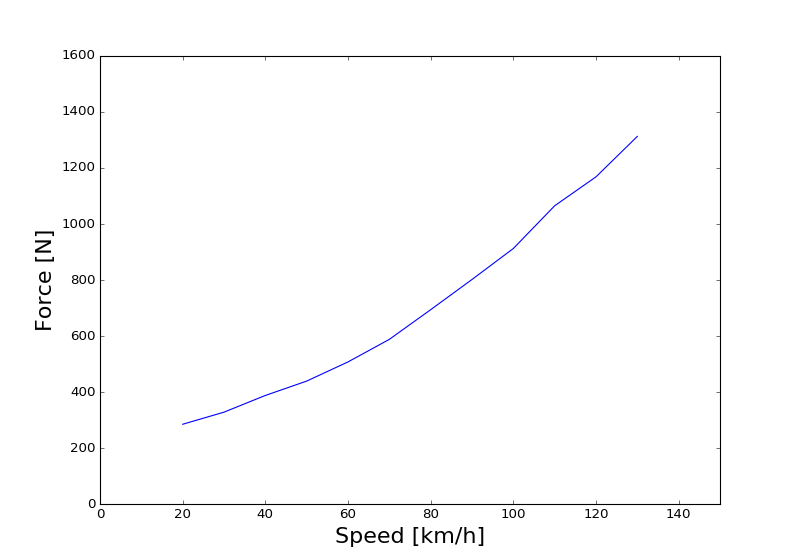

In [22]:
fig = plt.figure(1, figsize=(10, 7))
plot = fig.add_subplot(111)
plt.plot(ForcesDF)
plot.set_xlabel("Speed [km/h]",fontsize=20)
plot.set_ylabel("Force [N]",fontsize=20)
plot.set_xlim(0,150)
plot.set_ylim(0,1600)
plt.show()

Least square regression analysis over the range of the reference speed points

In [23]:
z = np.polyfit(ForcesDF.index, ForcesDF['Force'], 2)
print('F0: ', z[2],' N')
print('F1: ', z[1],' N /(km/h)')
print('F2: ', z[0],' N /(km/h)²')

F0:  231.82059365  N
F1:  1.59207693896  N /(km/h)
F2:  0.0522571841459  N /(km/h)²


### Correction to reference conditions and measurement equipment

Correction factors

In [24]:
#Air resistance correction factor (K2)
T = 298.88#Arithmetic average atmospheric temperature of all runs (K)
P = 1007.84#Arithmetic average of atmospheric pressure (kPa)
K2 = (T/293)*(1000/P)
#K2 = round(K2,4)
print('K2: ',K2)
#Rolling resistance correction factor (K0)
K0 = 0.0086
print('K0: ',K0,' K-¹')
#Wind correction for stationary anemometer (w1). Can be waived when the lowest arithmetic average is < 2 m/s (4.1.1.1.1)
vw = 0 #lower arithmetic average wind speed of opposite directions alongside the test road during the test (m/s)
w1 = 3.6 * 3.6 * z[0] * vw
#w1 = round(w1,4)
print('w1: ',w1,' N')
#Test mass correction factor (K1)
K1 = z[2] * (1-(testmass/mav))
#K1 = round(K1,4)
print('K1: ',K1,' N.Kg')

K2:  1.0121331356025416
K0:  0.0086  K-¹
w1:  0.0  N
K1:  -0.587879781024  N.Kg


Corrected forces

In [25]:
corForcesDF = pd.DataFrame(columns = ['corrected Force'])
#note that in formula 4.3.1.3.4.4. they are using 2 times the delta speed?? and here is only once, ie 10 km/h
for speed in speeds:
    corForcesDF.loc[speed] = pd.Series({
            'corrected Force':((z[2]-w1-K1)+z[1]*speed)*(1+K0*(T-273.15-20))+K2*z[0]*speed*speed,
        })
corForcesDF = corForcesDF.round(precision)
corForcesDF

,corrected Force
130,1354.891915
120,1205.958533
110,1067.603396
100,939.826505
90,822.627860
80,716.007460
70,619.965305
60,534.501396
50,459.615733
40,395.308315


Least square regression analysis over the range of the reference speed points

In [26]:
corr_z = np.polyfit(corForcesDF.index, corForcesDF['corrected Force'], 2)
print('F0: ', corr_z[2],' N')
print('F1: ', corr_z[1],' N /(km/h)')
print('F2: ', corr_z[0],' N /(km/h)²')

F0:  243.861097593  N
F1:  1.6705313271  N /(km/h)
F2:  0.0528912275  N /(km/h)²


# Default road loads based on vehicle parameters (5.2)

In [27]:
#f0 constant road load coefficient (N)
f0 = 0.140 * testmass
#f1 first order road load coefficient (0 by default)
f1 = 0
#f2 second order road load coefficient (N (h/km)**2)
f2 = (0.0000028 * testmass) + (0.017 * width * height)

In [28]:
print('The default road loads are: ') 
print('F0 ',f0,' N')
print('F1 ',f1,' N /(km/h)')
print('F2 ',f2,' N /(km/h)²')

The default road loads are: 
F0  332.08000000000004  N
F1  0  N /(km/h)
F2  0.06340885  N /(km/h)²
